# Downstream analysis pySCENIC

Downstream analysis using the loom file generated from [this notebook]("./pySCENIC_NK_mm.ipynb")

In [14]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pyscenic.utils import 
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

import warnings
warnings.filterwarnings('ignore')

In [15]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = "mm_exh_scenic_integrated-output.loom"

In [16]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)



## Extract relevant data from the integrated loom file


In [17]:


# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)



In [18]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)



In [19]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.label, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.percent_mt, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'ClusterID',
 'label',
 'percent_mt',
 'nGene',
 'nUMI']


In [20]:
# capture embeddings:

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

dr = pd.DataFrame()
dr.index = drx.index
dr["X"] = drx
dr["Y"] = dry




In [21]:
lf.close()

### Using anndata

In [22]:
adata = sc.read( f_final_loom, validate=False)

# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [23]:
adata.obsm["X_umap"] = np.array(dr)

In [24]:
sc._utils.sanitize_anndata( adata )

In [25]:
# load the regulons from a file using the load_signatures function
sig = load_signatures('Results/reg_mm_exh.csv')
adata = add_scenic_metadata(adata, auc_mtx, sig)


Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [26]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [27]:
df_motifs = load_motifs('Results/reg_mm_exh.csv')

In [31]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['ClusterID'] )
rss_cellType

,AEBP2_(+),ARID3A_(+),ARID3B_(+),ARNT_(+),ARNTL_(+),ATF1_(+),ATF2_(+),ATF4_(+),ATF6_(+),ATF6B_(+),...,ZNF652_(+),ZNF655_(+),ZNF677_(+),ZNF737_(+),ZNF75A_(+),ZNF791_(+),ZNF836_(+),ZNF84_(+),ZNF891_(+),ZNF92_(+)
NK exhausted,0.959234,0.977296,0.960208,0.978342,0.895944,0.988174,0.986944,0.943128,0.95644,0.974209,...,0.988026,0.978781,0.974328,0.932798,0.980012,0.922586,0.96156,0.965754,0.943523,0.946031


In [56]:
rss_cellType.iloc[0].sort_values(ascending=False)

BCLAF1_(+)    0.993178
EOMES_(+)     0.992444
ZBTB11_(+)    0.992221
BPTF_(+)      0.991878
GATAD1_(+)    0.991774
                ...   
ARNTL_(+)     0.895944
RUNX1_(+)     0.894502
ZFP14_(+)     0.886654
PBX3_(+)      0.865237
ZNF33A_(+)    0.836228
Name: NK exhausted, Length: 223, dtype: float64

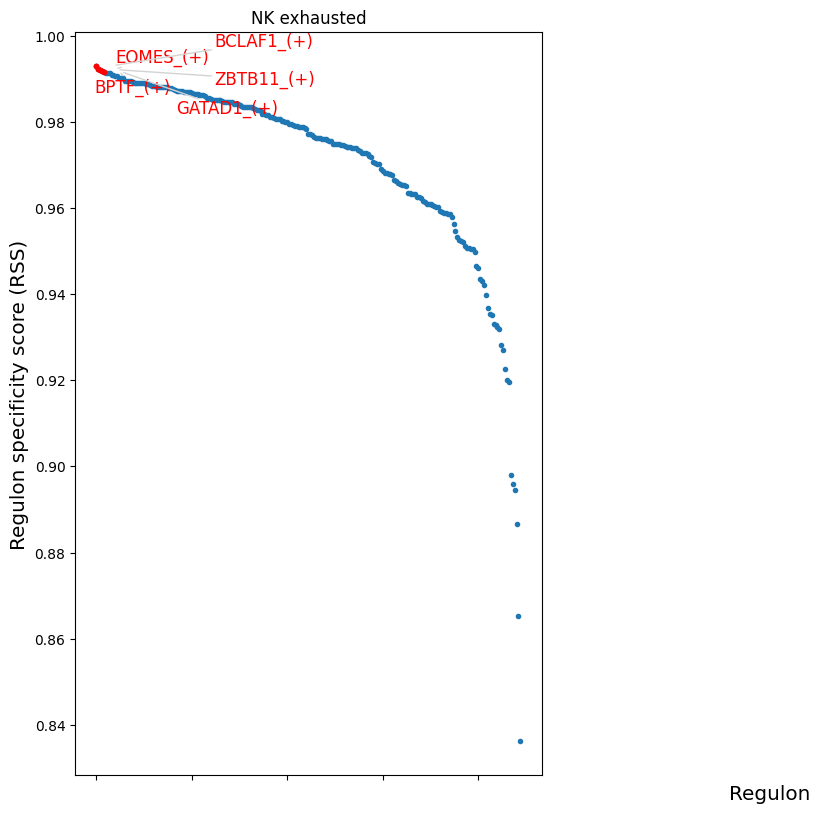

In [32]:
cats = sorted(list(set(cellAnnot['ClusterID'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("test_cell-state-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [42]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

topreg

['ZBTB11_(+)', 'GATAD1_(+)', 'BCLAF1_(+)', 'EOMES_(+)', 'BPTF_(+)']

In [34]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)



In [35]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f



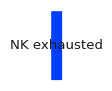

In [36]:


colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['ClusterID'] ]

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("test-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

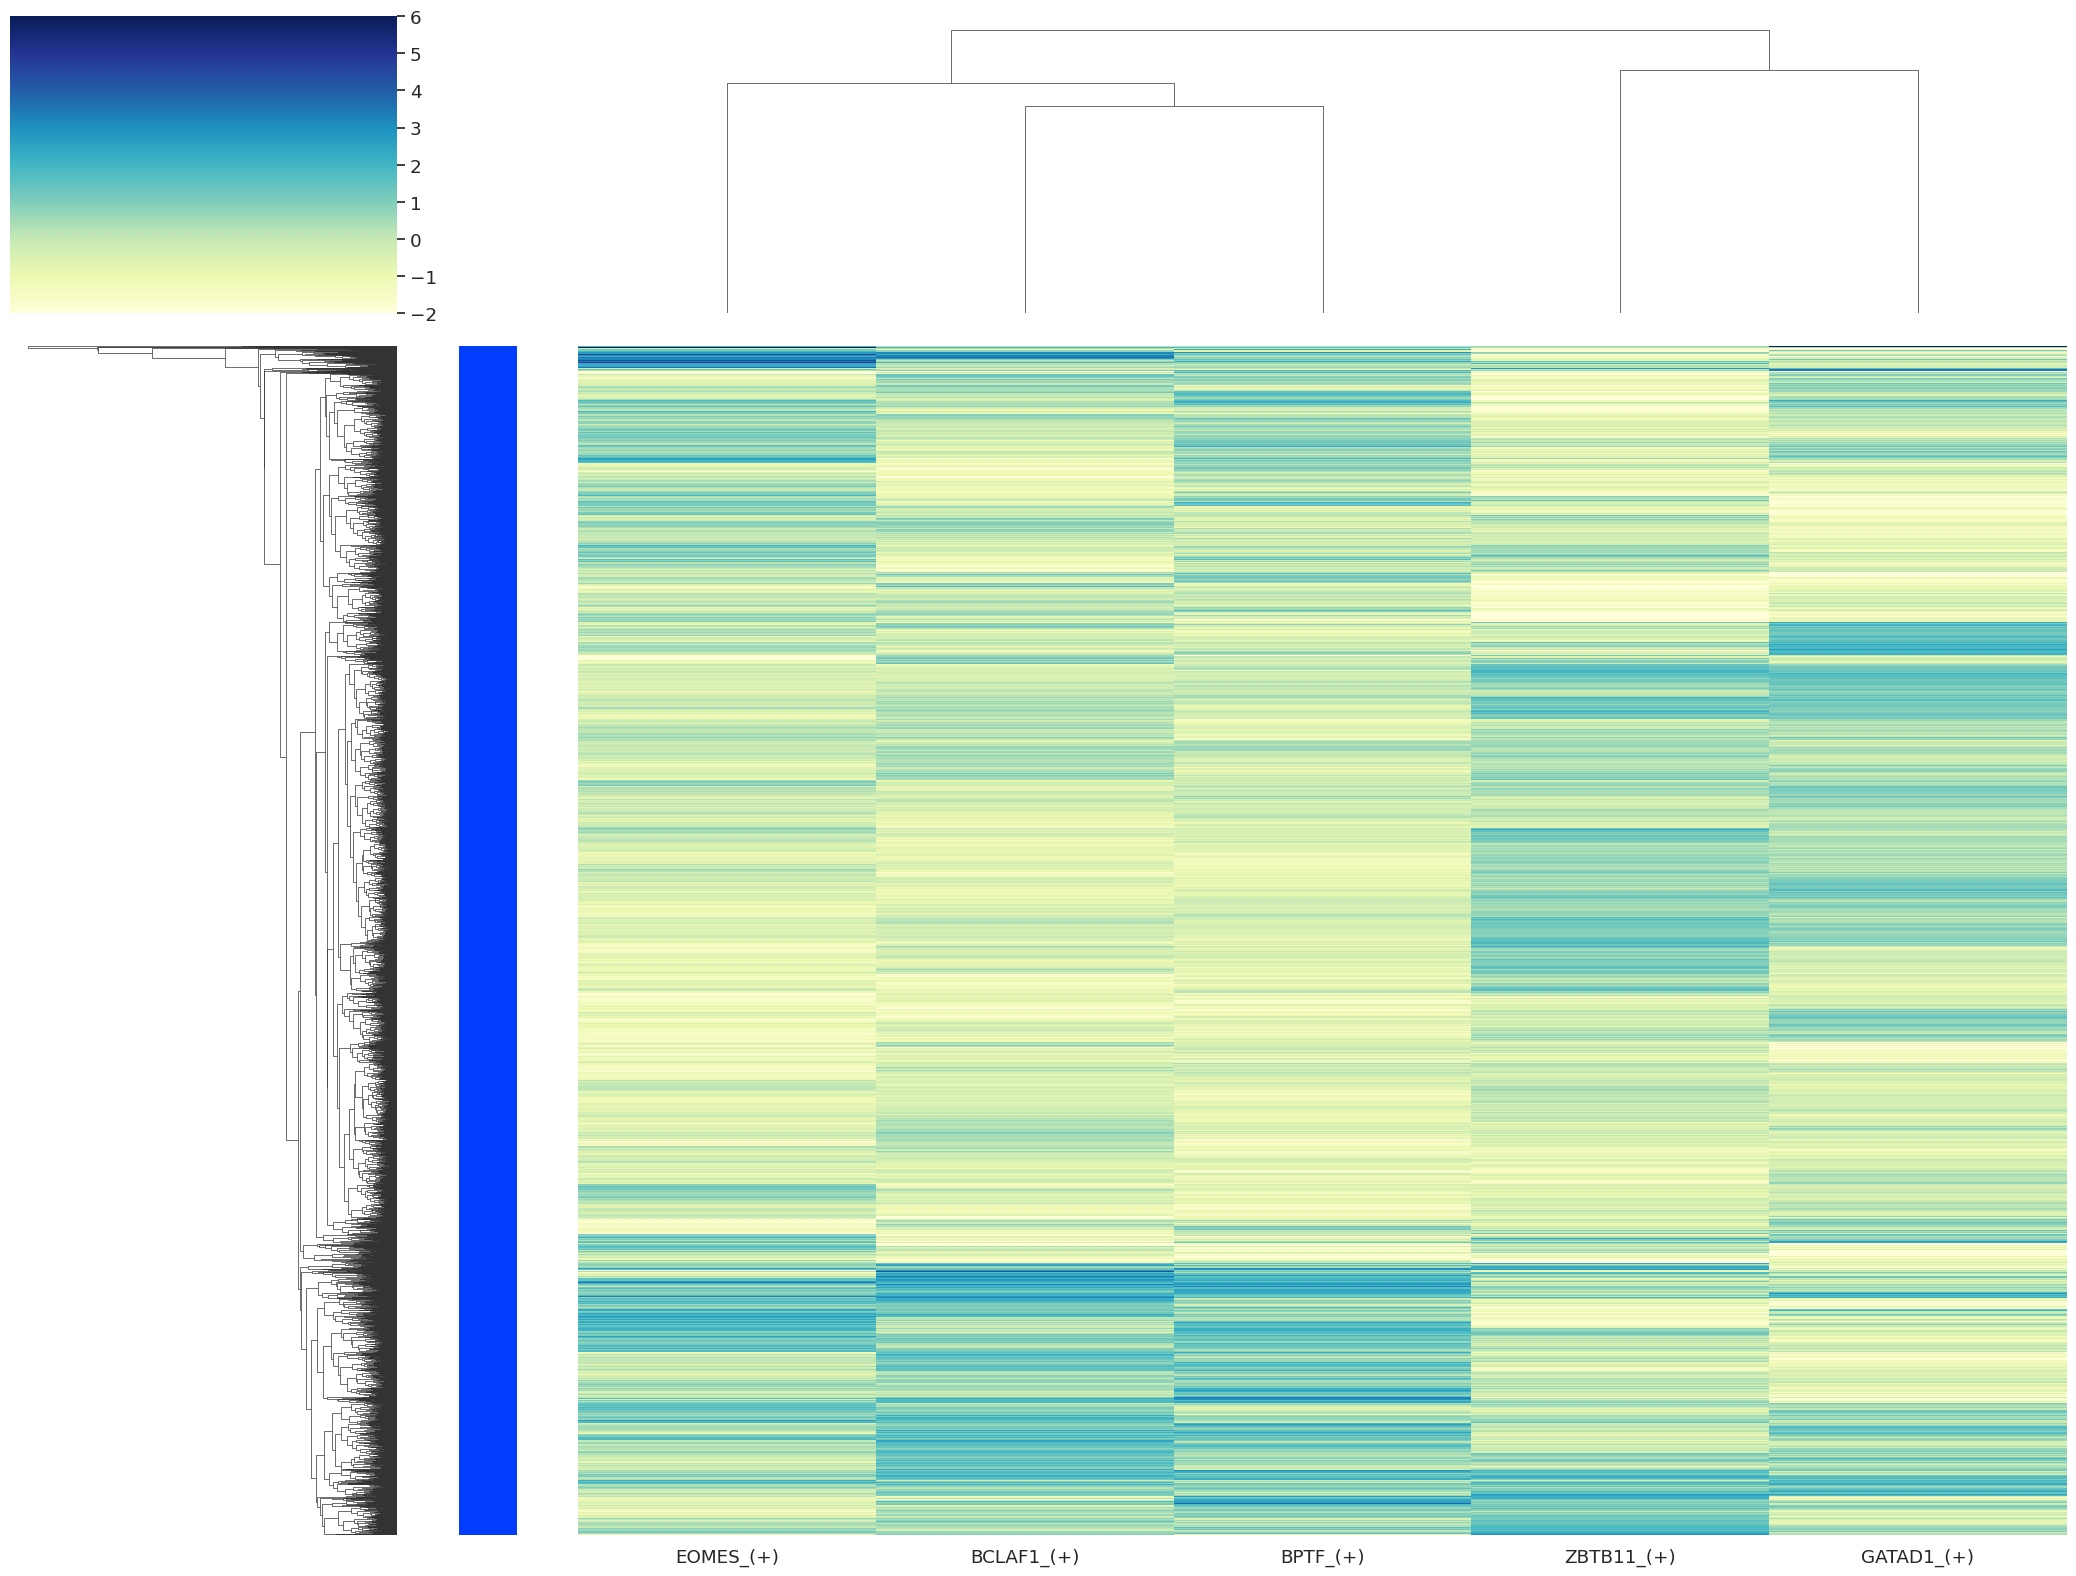

In [37]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("test-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [38]:
adjacencies = pd.read_csv("Results/adj_mm_exh.csv", index_col=False)

In [39]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

,AEBP2_(+),ARID3A_(+),ARID3B_(+),ARNT_(+),ARNTL_(+),ATF1_(+),ATF2_(+),ATF4_(+),ATF6_(+),ATF6B_(+),...,ZNF652_(+),ZNF655_(+),ZNF677_(+),ZNF737_(+),ZNF75A_(+),ZNF791_(+),ZNF836_(+),ZNF84_(+),ZNF891_(+),ZNF92_(+)
MGUS_CD138nCD45p_2_ACTGCTCGTCTAGGTT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
MGUS_CD138nCD45p_2_GCGAGAATCTGCGTAA-1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
MGUS_CD138nCD45p_2_GCGCCAACACTGTGTA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
MGUS_CD138nCD45p_2_TCGAGGCAGTCCCACG-1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
MGUS_CD138nCD45p_2_TTGGCAACAAGGACTG-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


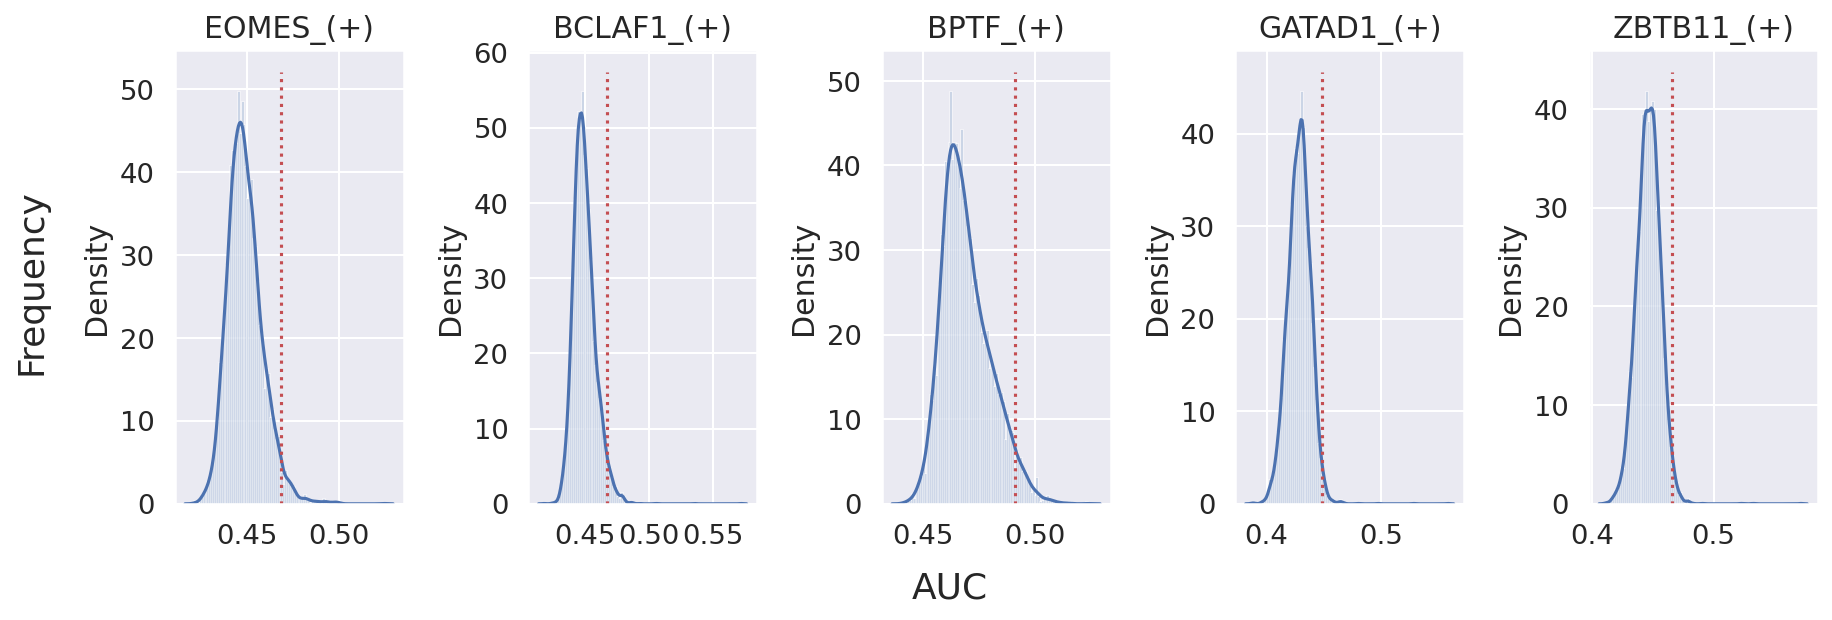

In [41]:
# select regulons:
r = [ 'EOMES_(+)', 'BCLAF1_(+)', 'BPTF_(+)','GATAD1_(+)','ZBTB11_(+)'  ]

fig, axs = plt.subplots(1, 5, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
#fig.savefig('PBMC10k_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

In [140]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2023-02-23 12:28:13,465 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-02-23 12:28:13,990 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-02-23 12:28:36,107 - pyscenic.utils - INFO - Creating modules.


In [141]:
tf = 'IRF2'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes' )

IRF2 module 0: 1450 genes
IRF2 module 1: 389 genes
IRF2 module 2: 51 genes
IRF2 module 3: 34 genes
IRF2 module 4: 651 genes
IRF2 regulon: 859 genes


In [160]:
[x.transcription_factor for x in modules if x.transcription_factor=="IRF2"]

['IRF2', 'IRF2', 'IRF2', 'IRF2', 'IRF2']

In [142]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'_(+)']:
        f.write("%s\n" % item)

In [65]:
with open("Results/regulons_mm_exh.json", "w") as outfile:
    json.dump(regulons, outfile)